<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/Factory/Kaggle_multi_stage_continuous_flow_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Description of physical setup:		
The data comes from a continuous flow process.		
Sample rate is 1 Hz.		
In the first stage, Machines 1, 2,  and 3 operate in parallel, and feed their outputs into a step that combines the flows.		
Output from the combiner is measured in 15 locations. These measurements are the primary measurements to predict.		
Next, the output flows into a second stage, where Machines 4 and 5 process in series.		
Measurements are made again in the same 15 locations. These are the secondary measurements to predict.		
		
Measurements are noisy.		
Each measurement also has a target or Setpoint (setpoints are included in the first row of data).		
The goal is to predict the measurements (or the error versus setpoints) for as many of the 15 measurements as possible.		
Some measurements will be more predictable than others!		
Prediction of measurements after the first stage are the primary interest.		
Prediction of measurements after the second stage are nice-to-have but the data is much more noisy.		
		
Note on variable naming conventions		

~.C.Setpoint		Setpoint for Controlled variable

~.C.Actual		Actual value of Controlled variable

~.U.Actual		Actual value of Uncontrolled variable

Others		Environmental or raw material variables, States / events, etc.
		
Start col	End col	Description
0	0	Time stamp

1	2	Factory ambient conditions

3	6	First stage, Machine 1, raw material properties (material going in to Machine 1)

7	14	First stage, Machine 1 process variables

15	18	First stage, Machine 2, raw material properties (material going in to Machine 2)

19	26	First stage, Machine 2 process variables

27	30	First stage, Machine 3, raw material properties (material going in to Machine 3)

31	38	First stage, Machine 3 process variables

39	41	Combiner stage process parameters. Here we combines the outputs from Machines 1, 2, and 3.

42	71	PRIMARY OUTPUT TO CONTROL: Measurements of 15 features (in mm), along with setpoint or target for each

72	78	Second stage, Machine 4 process variables

79	85	Second stage, Machine 5 process variables

86	115	SECONDARY OUTPUT TO CONTROL: Measurements of 15 features (in mm), along with setpoint or target for each
		
		
		
		

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv("/content/drive/My Drive/Data/continuous_factory_process.csv",
                 #decimal=",",parse_dates=["time_stamp"],infer_datetime_format=True
                 )
print(df.shape)
df.head()

(14088, 116)


,time_stamp,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,Machine1.MotorAmperage.U.Actual,Machine1.MotorRPM.C.Actual,Machine1.MaterialPressure.U.Actual,Machine1.MaterialTemperature.U.Actual,Machine1.ExitZoneTemperature.C.Actual,Machine2.RawMaterial.Property1,Machine2.RawMaterial.Property2,Machine2.RawMaterial.Property3,Machine2.RawMaterial.Property4,Machine2.RawMaterialFeederParameter.U.Actual,Machine2.Zone1Temperature.C.Actual,Machine2.Zone2Temperature.C.Actual,Machine2.MotorAmperage.U.Actual,Machine2.MotorRPM.C.Actual,Machine2.MaterialPressure.U.Actual,Machine2.MaterialTemperature.U.Actual,Machine2.ExitZoneTemperature.C.Actual,Machine3.RawMaterial.Property1,Machine3.RawMaterial.Property2,Machine3.RawMaterial.Property3,Machine3.RawMaterial.Property4,Machine3.RawMaterialFeederParameter.U.Actual,Machine3.Zone1Temperature.C.Actual,Machine3.Zone2Temperature.C.Actual,Machine3.MotorAmperage.U.Actual,Machine3.MotorRPM.C.Actual,Machine3.MaterialPressure.U.Actual,Machine3.MaterialTemperature.U.Actual,Machine3.ExitZoneTemperature.C.Actual,FirstStage.CombinerOperation.Temperature1.U.Actual,...,Machine4.Temperature4.C.Actual,Machine4.Temperature5.C.Actual,Machine4.ExitTemperature.U.Actual,Machine5.Temperature1.C.Actual,Machine5.Temperature2.C.Actual,Machine5.Temperature3.C.Actual,Machine5.Temperature4.C.Actual,Machine5.Temperature5.C.Actual,Machine5.Temperature6.C.Actual,Machine5.ExitTemperature.U.Actual,Stage2.Output.Measurement0.U.Actual,Stage2.Output.Measurement0.U.Setpoint,Stage2.Output.Measurement1.U.Actual,Stage2.Output.Measurement1.U.Setpoint,Stage2.Output.Measurement2.U.Actual,Stage2.Output.Measurement2.U.Setpoint,Stage2.Output.Measurement3.U.Actual,Stage2.Output.Measurement3.U.Setpoint,Stage2.Output.Measurement4.U.Actual,Stage2.Output.Measurement4.U.Setpoint,Stage2.Output.Measurement5.U.Actual,Stage2.Output.Measurement5.U.Setpoint,Stage2.Output.Measurement6.U.Actual,Stage2.Output.Measurement6.U.Setpoint,Stage2.Output.Measurement7.U.Actual,Stage2.Output.Measurement7.U.Setpoint,Stage2.Output.Measurement8.U.Actual,Stage2.Output.Measurement8.U.Setpoint,Stage2.Output.Measurement9.U.Actual,Stage2.Output.Measurement9.U.Setpoint,Stage2.Output.Measurement10.U.Actual,Stage2.Output.Measurement10.U.Setpoint,Stage2.Output.Measurement11.U.Actual,Stage2.Output.Measurement11.U.Setpoint,Stage2.Output.Measurement12.U.Actual,Stage2.Output.Measurement12.U.Setpoint,Stage2.Output.Measurement13.U.Actual,Stage2.Output.Measurement13.U.Setpoint,Stage2.Output.Measurement14.U.Actual,Stage2.Output.Measurement14.U.Setpoint
0,2019-03-06 10:52:33,17.24,23.53,11.54,200,963.0,247,1241.26,72.0,72.3,48.03,10.48,436.76,76.3,75.1,12.59,236,601.11,257,200.75,69.37,69.06,73.25,13.89,246.68,68.8,60.1,9.02,186,421.16,200,203.95,78.2,78.4,337.40,13.50,263.71,65.3,65.0,99.1,...,21.0,260.0,35.0,309.8,289.9,263.9,238.6,245.0,66.1,50.0,0.0,12.05,0.0,11.71,0.0,11,0.0,20.73,0.0,31.36,0.0,2.71,0.0,0.01,0.0,2.75,0.0,19.39,0.0,16.47,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
1,2019-03-06 10:52:34,17.24,23.53,11.54,200,963.0,247,1246.09,72.0,72.3,48.03,10.48,436.77,76.3,75.1,12.59,236,601.11,257,220.16,69.35,69.05,73.19,13.89,246.02,69.0,60.0,9.02,186,421.16,200,213.36,78.1,78.4,341.85,13.59,262.88,65.3,65.0,99.1,...,23.0,263.0,35.0,309.8,289.9,263.9,238.6,245.0,66.1,49.8,0.0,12.05,0.0,11.71,0.0,11,0.0,20.73,0.0,31.36,0.0,2.71,0.0,0.01,0.0,2.75,0.0,19.39,0.0,16.47,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
2,2019-03-06 10:52:35,17.24,23.53,11.54,200,963.0,247,1246.29,72.0,72.3,48.16,10.48,425.46,76.3,75.1,12.59,236,601.11,257,216.84,69.37,69.07,73.19,13.85,247.18,68.9,60.0,9.02,186,421.16,200,225.25,78.1,78.5,338.71,14.00,262.63,65.3,65.0,99.6,...,22.0,266.0,35.0,309.8,289.9,263.9,238.6,245.0,66.1,

In [4]:
df.columns[:30]

Index(['time_stamp', 'AmbientConditions.AmbientHumidity.U.Actual',
       'AmbientConditions.AmbientTemperature.U.Actual',
       'Machine1.RawMaterial.Property1', 'Machine1.RawMaterial.Property2',
       'Machine1.RawMaterial.Property3', 'Machine1.RawMaterial.Property4',
       'Machine1.RawMaterialFeederParameter.U.Actual',
       'Machine1.Zone1Temperature.C.Actual',
       'Machine1.Zone2Temperature.C.Actual', 'Machine1.MotorAmperage.U.Actual',
       'Machine1.MotorRPM.C.Actual', 'Machine1.MaterialPressure.U.Actual',
       'Machine1.MaterialTemperature.U.Actual',
       'Machine1.ExitZoneTemperature.C.Actual',
       'Machine2.RawMaterial.Property1', 'Machine2.RawMaterial.Property2',
       'Machine2.RawMaterial.Property3', 'Machine2.RawMaterial.Property4',
       'Machine2.RawMaterialFeederParameter.U.Actual',
       'Machine2.Zone1Temperature.C.Actual',
       'Machine2.Zone2Temperature.C.Actual', 'Machine2.MotorAmperage.U.Actual',
       'Machine2.MotorRPM.C.Actual', 'Machine2

In [ ]:
df.columns[-1:]

Index(['Stage2.Output.Measurement14.U.Setpoint'], dtype='object')

In [ ]:
df.describe()

,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,Machine1.MotorAmperage.U.Actual,Machine1.MotorRPM.C.Actual,Machine1.MaterialPressure.U.Actual,Machine1.MaterialTemperature.U.Actual,Machine1.ExitZoneTemperature.C.Actual,Machine2.RawMaterial.Property1,Machine2.RawMaterial.Property2,Machine2.RawMaterial.Property3,Machine2.RawMaterial.Property4,Machine2.RawMaterialFeederParameter.U.Actual,Machine2.Zone1Temperature.C.Actual,Machine2.Zone2Temperature.C.Actual,Machine2.MotorAmperage.U.Actual,Machine2.MotorRPM.C.Actual,Machine2.MaterialPressure.U.Actual,Machine2.MaterialTemperature.U.Actual,Machine2.ExitZoneTemperature.C.Actual,Machine3.RawMaterial.Property1,Machine3.RawMaterial.Property2,Machine3.RawMaterial.Property3,Machine3.RawMaterial.Property4,Machine3.RawMaterialFeederParameter.U.Actual,Machine3.Zone1Temperature.C.Actual,Machine3.Zone2Temperature.C.Actual,Machine3.MotorAmperage.U.Actual,Machine3.MotorRPM.C.Actual,Machine3.MaterialPressure.U.Actual,Machine3.MaterialTemperature.U.Actual,Machine3.ExitZoneTemperature.C.Actual,FirstStage.CombinerOperation.Temperature1.U.Actual,FirstStage.CombinerOperation.Temperature2.U.Actual,...,Machine4.Temperature4.C.Actual,Machine4.Temperature5.C.Actual,Machine4.ExitTemperature.U.Actual,Machine5.Temperature1.C.Actual,Machine5.Temperature2.C.Actual,Machine5.Temperature3.C.Actual,Machine5.Temperature4.C.Actual,Machine5.Temperature5.C.Actual,Machine5.Temperature6.C.Actual,Machine5.ExitTemperature.U.Actual,Stage2.Output.Measurement0.U.Actual,Stage2.Output.Measurement0.U.Setpoint,Stage2.Output.Measurement1.U.Actual,Stage2.Output.Measurement1.U.Setpoint,Stage2.Output.Measurement2.U.Actual,Stage2.Output.Measurement2.U.Setpoint,Stage2.Output.Measurement3.U.Actual,Stage2.Output.Measurement3.U.Setpoint,Stage2.Output.Measurement4.U.Actual,Stage2.Output.Measurement4.U.Setpoint,Stage2.Output.Measurement5.U.Actual,Stage2.Output.Measurement5.U.Setpoint,Stage2.Output.Measurement6.U.Actual,Stage2.Output.Measurement6.U.Setpoint,Stage2.Output.Measurement7.U.Actual,Stage2.Output.Measurement7.U.Setpoint,Stage2.Output.Measurement8.U.Actual,Stage2.Output.Measurement8.U.Setpoint,Stage2.Output.Measurement9.U.Actual,Stage2.Output.Measurement9.U.Setpoint,Stage2.Output.Measurement10.U.Actual,Stage2.Output.Measurement10.U.Setpoint,Stage2.Output.Measurement11.U.Actual,Stage2.Output.Measurement11.U.Setpoint,Stage2.Output.Measurement12.U.Actual,Stage2.Output.Measurement12.U.Setpoint,Stage2.Output.Measurement13.U.Actual,Stage2.Output.Measurement13.U.Setpoint,Stage2.Output.Measurement14.U.Actual,Stage2.Output.Measurement14.U.Setpoint
count,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,...,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,1.408800e+04,1.408800e+04,14088.000000,1.408800e+04,1.408800e+04,14088.0,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,14088.00,1.408800e+04,1.408800e+04,14088.000000,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,14088.000000,1.408800e+04
mean,15.330759,23.843635,11.851256,205.676320,951.679815,248.868896,1242.764276,72.013330,72.013106,

# Predict stage 1

Chỉ lấy dữ liệu actual , không lấy dữ liệu set point

In [ ]:
list(range(43,73,2))

[43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71]

In [ ]:
df_new=df.drop(df.columns[list(range(43,73,2)) + list(range(87,116,2))],axis=1)

In [ ]:
df_new

,time_stamp,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,Machine1.MotorAmperage.U.Actual,Machine1.MotorRPM.C.Actual,Machine1.MaterialPressure.U.Actual,Machine1.MaterialTemperature.U.Actual,Machine1.ExitZoneTemperature.C.Actual,Machine2.RawMaterial.Property1,Machine2.RawMaterial.Property2,Machine2.RawMaterial.Property3,Machine2.RawMaterial.Property4,Machine2.RawMaterialFeederParameter.U.Actual,Machine2.Zone1Temperature.C.Actual,Machine2.Zone2Temperature.C.Actual,Machine2.MotorAmperage.U.Actual,Machine2.MotorRPM.C.Actual,Machine2.MaterialPressure.U.Actual,Machine2.MaterialTemperature.U.Actual,Machine2.ExitZoneTemperature.C.Actual,Machine3.RawMaterial.Property1,Machine3.RawMaterial.Property2,Machine3.RawMaterial.Property3,Machine3.RawMaterial.Property4,Machine3.RawMaterialFeederParameter.U.Actual,Machine3.Zone1Temperature.C.Actual,Machine3.Zone2Temperature.C.Actual,Machine3.MotorAmperage.U.Actual,Machine3.MotorRPM.C.Actual,Machine3.MaterialPressure.U.Actual,Machine3.MaterialTemperature.U.Actual,Machine3.ExitZoneTemperature.C.Actual,FirstStage.CombinerOperation.Temperature1.U.Actual,...,Stage1.Output.Measurement4.U.Actual,Stage1.Output.Measurement5.U.Actual,Stage1.Output.Measurement6.U.Actual,Stage1.Output.Measurement7.U.Actual,Stage1.Output.Measurement8.U.Actual,Stage1.Output.Measurement9.U.Actual,Stage1.Output.Measurement10.U.Actual,Stage1.Output.Measurement11.U.Actual,Stage1.Output.Measurement12.U.Actual,Stage1.Output.Measurement13.U.Actual,Stage1.Output.Measurement14.U.Actual,Machine4.Temperature1.C.Actual,Machine4.Temperature2.C.Actual,Machine4.Pressure.C.Actual,Machine4.Temperature3.C.Actual,Machine4.Temperature4.C.Actual,Machine4.Temperature5.C.Actual,Machine4.ExitTemperature.U.Actual,Machine5.Temperature1.C.Actual,Machine5.Temperature2.C.Actual,Machine5.Temperature3.C.Actual,Machine5.Temperature4.C.Actual,Machine5.Temperature5.C.Actual,Machine5.Temperature6.C.Actual,Machine5.ExitTemperature.U.Actual,Stage2.Output.Measurement0.U.Actual,Stage2.Output.Measurement1.U.Actual,Stage2.Output.Measurement2.U.Actual,Stage2.Output.Measurement3.U.Actual,Stage2.Output.Measurement4.U.Actual,Stage2.Output.Measurement5.U.Actual,Stage2.Output.Measurement6.U.Actual,Stage2.Output.Measurement7.U.Actual,Stage2.Output.Measurement8.U.Actual,Stage2.Output.Measurement9.U.Actual,Stage2.Output.Measurement10.U.Actual,Stage2.Output.Measurement11.U.Actual,Stage2.Output.Measurement12.U.Actual,Stage2.Output.Measurement13.U.Actual,Stage2.Output.Measurement14.U.Actual
0,2019-03-06 10:52:33,17.24,23.53,11.54,200,963.00,247,1241.26,72.0,72.3,48.03,10.48,436.76,76.3,75.1,12.59,236,601.11,257,200.75,69.37,69.06,73.25,13.89,246.68,68.8,60.1,9.02,186,421.16,200,203.95,78.2,78.4,337.40,13.50,263.71,65.3,65.0,99.1,...,0.00,0.0,3.82,2.94,20.82,17.30,8.06,5.54,1.66,2.69,14.51,298.0,284.0,21.0,268.0,21.0,260.0,35.0,309.8,289.9,263.9,238.6,245.0,66.1,50.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
1,2019-03-06 10:52:34,17.24,23.53,11.54,200,963.00,247,1246.09,72.0,72.3,48.03,10.48,436.77,76.3,75.1,12.59,236,601.11,257,220.16,69.35,69.05,73.19,13.89,246.02,69.0,60.0,9.02,186,421.16,200,213.36,78.1,78.4,341.85,13.59,262.88,65.3,65.0,99.1,...,0.00,0.0,3.97,0.00,19.65,17.31,7.55,5.13,1.04,2.70,0.00,301.0,287.0,23.0,270.0,23.0,263.0,35.0,309.8,289.9,263.9,238.6,245.0,66.1,49.8,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
2,2019-03-06 10:52:35,17.24,23.53,11.54,200,963.00,247,1246.29,72.0,72.3,48.16,10.48,425.46,76.3,75.1,12.59,236,601.11,257,216.84,69.37,69.07,73.19,13.85,247.18,68.9,60.0,9.02,186,421.16,200,225.25,78.1,78.5,338.71,14.00,262.63,65.3,65.0,99.6,...,0.00,0.0,3.97,0.00,19.65,17.31,7.55,5.13,1.04,2.70,0.00,304.0,289.0,22.0,275.

Remove 29 unsued column

In [ ]:
X=df_new.iloc[:, 1:42]
X.head()

,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,Machine1.MotorAmperage.U.Actual,Machine1.MotorRPM.C.Actual,Machine1.MaterialPressure.U.Actual,Machine1.MaterialTemperature.U.Actual,Machine1.ExitZoneTemperature.C.Actual,Machine2.RawMaterial.Property1,Machine2.RawMaterial.Property2,Machine2.RawMaterial.Property3,Machine2.RawMaterial.Property4,Machine2.RawMaterialFeederParameter.U.Actual,Machine2.Zone1Temperature.C.Actual,Machine2.Zone2Temperature.C.Actual,Machine2.MotorAmperage.U.Actual,Machine2.MotorRPM.C.Actual,Machine2.MaterialPressure.U.Actual,Machine2.MaterialTemperature.U.Actual,Machine2.ExitZoneTemperature.C.Actual,Machine3.RawMaterial.Property1,Machine3.RawMaterial.Property2,Machine3.RawMaterial.Property3,Machine3.RawMaterial.Property4,Machine3.RawMaterialFeederParameter.U.Actual,Machine3.Zone1Temperature.C.Actual,Machine3.Zone2Temperature.C.Actual,Machine3.MotorAmperage.U.Actual,Machine3.MotorRPM.C.Actual,Machine3.MaterialPressure.U.Actual,Machine3.MaterialTemperature.U.Actual,Machine3.ExitZoneTemperature.C.Actual,FirstStage.CombinerOperation.Temperature1.U.Actual,FirstStage.CombinerOperation.Temperature2.U.Actual,FirstStage.CombinerOperation.Temperature3.C.Actual
0,17.24,23.53,11.54,200,963.0,247,1241.26,72.0,72.3,48.03,10.48,436.76,76.3,75.1,12.59,236,601.11,257,200.75,69.37,69.06,73.25,13.89,246.68,68.8,60.1,9.02,186,421.16,200,203.95,78.2,78.4,337.40,13.50,263.71,65.3,65.0,99.1,108.2,80.0
1,17.24,23.53,11.54,200,963.0,247,1246.09,72.0,72.3,48.03,10.48,436.77,76.3,75.1,12.59,236,601.11,257,220.16,69.35,69.05,73.19,13.89,246.02,69.0,60.0,9.02,186,421.16,200,213.36,78.1,78.4,341.85,13.59,262.88,65.3,65.0,99.1,109.2,80.0
2,17.24,23.53,11.54,200,963.0,247,1246.29,72.0,72.3,48.16,10.48,425.46,76.3,75.1,12.59,236,601.11,257,216.84,69.37,69.07,73.19,13.85,247.18,68.9,60.0,9.02,186,421.16,200,225.25,78.1,78.5,338.71,14.00,262.63,65.3,65.0,99.6,111.0,80.0
3,17.24,23.53,11.54,200,963.0,247,1247.59,72.0,72.3,48.57,10.48,437.01,76.3,75.1,12.59,236,601.11,257,208.61,69.38,69.08,72.81,13.90,249.92,69.1,59.9,9.02,186,421.16,200,213.99,78.1,78.5,339.15,13.67,262.22,65.4,65.0,99.6,109.2,80.0
4,17.24,23.53,11.54,200,963.0,247,1252.83,72.1,72.4,48.57,10.48,425.18,76.4,75.1,12.59,236,601.11,257,212.31,69.40,69.07,73.00,13.89,250.58,68.9,59.9,9.02,186,421.16,200,200.86,78.0,78.5,337.05,13.72,262.17,65.4,65.0,99.6,109.8,80.0


In [ ]:
y=df_new.iloc[:,42:(42+15)]
y.head()

,Stage1.Output.Measurement0.U.Actual,Stage1.Output.Measurement1.U.Actual,Stage1.Output.Measurement2.U.Actual,Stage1.Output.Measurement3.U.Actual,Stage1.Output.Measurement4.U.Actual,Stage1.Output.Measurement5.U.Actual,Stage1.Output.Measurement6.U.Actual,Stage1.Output.Measurement7.U.Actual,Stage1.Output.Measurement8.U.Actual,Stage1.Output.Measurement9.U.Actual,Stage1.Output.Measurement10.U.Actual,Stage1.Output.Measurement11.U.Actual,Stage1.Output.Measurement12.U.Actual,Stage1.Output.Measurement13.U.Actual,Stage1.Output.Measurement14.U.Actual
0,12.72,0.0,12.16,21.97,0.00,0.0,3.82,2.94,20.82,17.30,8.06,5.54,1.66,2.69,14.51
1,12.34,0.0,0.00,17.78,0.00,0.0,3.97,0.00,19.65,17.31,7.55,5.13,1.04,2.70,0.00
2,12.34,0.0,0.00,17.78,0.00,0.0,3.97,0.00,19.65,17.31,7.55,5.13,1.04,2.70,0.00
3,12.34,0.0,0.00,17.78,0.00,0.0,3.97,0.00,19.65,17.31,7.55,5.13,1.04,2.70,0.00
4,12.29,0.0,0.00,17.83,31.44,0.0,3.87,0.00,0.00,17.30,7.54,5.15,1.15,2.72,0.00


## All ML method 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate,cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle

# Score:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
#ML normal ML
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR

from sklearn.linear_model import TheilSenRegressor, HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures

#ML ensembles
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

#Special
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)
#transform=StandardScaler()
transform=RobustScaler()

X_train = transform.fit_transform(X_train)
X_test = transform.fit_transform(X_test)

In [ ]:
# Creating a list of the classifiers
from sklearn.multioutput import MultiOutputRegressor
regression = {

    'LR':LinearRegression(),
    'LASSO':Lasso(), 
    'Ridge':Ridge(), 
    'EN':ElasticNet(),
    'KNN':KNeighborsRegressor(), # kha lau
    'CART':DecisionTreeRegressor(), 
    #'SVR':MultiOutputRegressor(LinearSVR(max_iter=10000)),
    # New , Theil, Huber Regressor:
    #'RANSAC':RANSACRegressor(),
    #'TheilSen':TheilSenRegressor(),
    #'Huber':MultiOutputRegressor(HuberRegressor(max_iter=10000)),
    #New: Poly nominal
    #'Poly2':Pipeline([('Poly2', PolynomialFeatures(degree=2)),
    #                 ('linear', LinearRegression(fit_intercept=False))]),
    
    #Ensemble:
    #'AB':AdaBoostRegressor(), #Bagging (very long)
    #'GBM':GradientBoostingRegressor(),  #Boosting
    #'RF':RandomForestRegressor(), #Boosting
    #'ET':ExtraTreesRegressor(), #Bagging (very long)
    #New from Matt cookbook
    #'XGB':XGBRegressor(), #New Boosting
    #'LGBM':LGBMRegressor(), #New Boosting   
}

In [ ]:
#Cross validate
import time
num_folds = 3
seed = 7

scoring = {'mse' : make_scorer(mean_squared_error), 
           'r2' : make_scorer(r2_score),
           }

names = []
train_rmse=[]
train_r2=[]
test_rmse=[]
test_r2=[]
fit_time=[]
time_=[]

for name, model in regression.items():
  print(name)
  start=time.time()
  estimator = model
  cv_results = cross_validate(estimator, X_train, y_train, cv=3, scoring=scoring,
                              return_train_score=True,
                              return_estimator=True
                              )

  # Time :
  time_cal=time.time() - start
  print('time : %0.3f' % (time_cal),'\n')
  
  #results.append(cv_results) # array of values
  names.append(name)
  train_rmse.append(np.sqrt(cv_results['train_mse'].mean()))
  train_r2.append(cv_results['train_r2'].mean())
  

  test_rmse.append(np.sqrt(cv_results['test_mse'].mean()))
  test_r2.append(cv_results['test_r2'].mean())
  

  fit_time.append(cv_results['fit_time'].mean())
  time_.append(time_cal)

  #print(cv_results.keys())
  print("%s: train_mse: %0.2f train_r2: %0.2f \
  test_mse: %0.2f test_r2: %0.2f fit_time: %0.2f" % 
       (name, cv_results['train_mse'].mean(),cv_results['train_r2'].mean(),
       cv_results['test_mse'].mean(),cv_results['test_r2'].mean(),
       cv_results['fit_time'].mean()))


LR
time : 0.114 

LR: train_mse: 6.12 train_r2: 0.38   test_mse: 6.20 test_r2: 0.37 fit_time: 0.02
LASSO
time : 0.207 

LASSO: train_mse: 8.52 train_r2: 0.20   test_mse: 8.54 test_r2: 0.19 fit_time: 0.05
Ridge
time : 0.076 

Ridge: train_mse: 6.12 train_r2: 0.38   test_mse: 6.20 test_r2: 0.37 fit_time: 0.01
EN
time : 0.262 

EN: train_mse: 8.15 train_r2: 0.22   test_mse: 8.17 test_r2: 0.22 fit_time: 0.07
KNN
time : 8.710 

KNN: train_mse: 3.51 train_r2: 0.64   test_mse: 5.42 test_r2: 0.46 fit_time: 0.05
CART
time : 1.036 

CART: train_mse: 0.00 train_r2: 1.00   test_mse: 5.86 test_r2: 0.35 fit_time: 0.33


In [ ]:
df_results_val=pd.DataFrame(list(zip(names,test_rmse,test_r2,
                                     train_rmse,train_r2,
                                     fit_time,time_)),
                  columns=['Names','test_rmse','test_r2',
                           'train_rmse','train_r2',
                           'fit_time','time'])
df_results_val=df_results_val.sort_values(by='test_rmse',ascending=True)
df_results_val

,Names,test_rmse,test_r2,train_rmse,train_r2,fit_time,time
4,KNN,2.328008,0.455795,1.874189e+00,0.644953,0.054260,8.709924
5,CART,2.421016,0.347679,9.195394e-17,1.000000,0.333821,1.035926
2,Ridge,2.489530,0.370415,2.473957e+00,0.379273,0.011241,0.076364
0,LR,2.489608,0.370369,2.473907e+00,0.379292,0.023153,0.113868
3,EN,2.858924,0.219068,2.854565e+00,0.220824,0.067568,0.261557
1,LASSO,2.922328,0.194791,2.919002e+00,0.196001,0.054416,0.207346


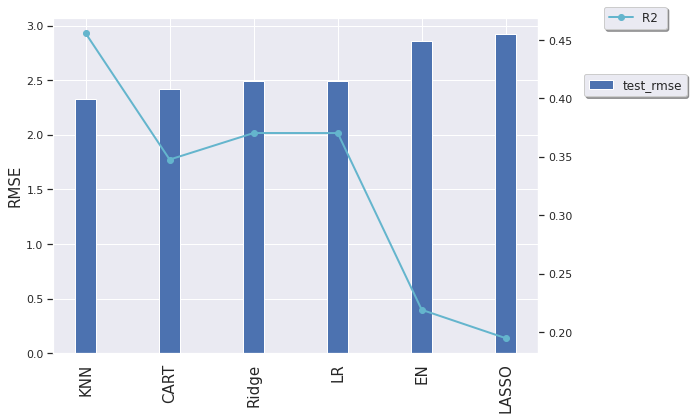

In [ ]:
# Define name:
name=df_results_val['Names']
test_rmse=df_results_val['test_rmse']
test_r2=df_results_val['test_r2']
#time = df_results_val['time']
# Plot:
x = np.arange(len(name))
fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x, test_rmse, color = 'b', width = 0.25,label='test_rmse')
#rects2 = ax.plot(x, test_r2, color = 'g',marker='o',label='test_r2')

ax2 = ax.twinx()
ax2.plot(x,test_r2,color ='c',marker='o',lw=2,label='R2 ')
ax2.secondary_yaxis('right')

ax.set_xticks(x)
ax.set_xticklabels(name,fontsize=15,rotation=90)
ax.set_ylabel('RMSE',fontsize=15)
ax2.set_ylabel('R2',fontsize=15)
#plt.gca().legend(loc ='center',bbox_to_anchor=(0.5, -0.2))
legend1=ax.legend(loc='center',bbox_to_anchor=(1.2, 0.8),shadow=True, fontsize='medium')
legend2=ax2.legend(loc='center',bbox_to_anchor=(1.2,1),shadow=True, fontsize='medium')

plt.axis('off')
fig.tight_layout()
plt.show()

In [ ]:
model=KNeighborsRegressor()
model.fit(X_train,y_train)
y_test_pred=model.predict(X_test)
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('test mae:', mean_absolute_error(y_test, y_test_pred))

test rmse: 2.544256206357947
test mae: 0.7469571535796995


In [ ]:
y_test

,Stage1.Output.Measurement0.U.Actual,Stage1.Output.Measurement1.U.Actual,Stage1.Output.Measurement2.U.Actual,Stage1.Output.Measurement3.U.Actual,Stage1.Output.Measurement4.U.Actual,Stage1.Output.Measurement5.U.Actual,Stage1.Output.Measurement6.U.Actual,Stage1.Output.Measurement7.U.Actual,Stage1.Output.Measurement8.U.Actual,Stage1.Output.Measurement9.U.Actual,Stage1.Output.Measurement10.U.Actual,Stage1.Output.Measurement11.U.Actual,Stage1.Output.Measurement12.U.Actual,Stage1.Output.Measurement13.U.Actual,Stage1.Output.Measurement14.U.Actual
1634,12.73,0.00,11.74,21.80,32.50,0.0,2.19,2.90,21.00,18.84,7.97,5.86,1.92,3.23,14.56
5598,13.05,13.91,11.21,21.55,33.37,0.0,1.76,2.92,20.90,18.87,7.78,0.00,1.64,3.02,15.80
8496,13.11,13.82,11.31,21.51,33.60,0.0,1.67,0.00,20.92,18.87,7.85,0.00,1.51,3.06,15.78
12366,12.84,0.00,11.09,21.64,34.29,0.0,0.00,0.00,20.92,19.30,7.39,0.00,1.41,3.38,0.00
795,12.79,0.00,11.71,21.54,32.66,0.0,2.18,2.89,21.07,18.73,7.96,5.83,1.90,3.21,14.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11674,12.98,0.00,11.57,21.53,34.44,0.0,1.55,0.00,21.04,18.95,7.70,0.00,1.43,3.46,15.11
4438,13.02,13.81,11.12,21.61,33.48,0.0,1.69,2.91,20.92,19.22,7.74,0.00,1.68,3.03,15.73
13203,12.90,0.00,11.36,21.73,34.15,0.0,0.00,0.00,20.88,18.98,7.60,0.00,1.41,3.35,0.00
12431,12.82,0.00,10.87,21.65,34.47,0.0,0.00,0.00,20.88,19.16,7.44,0.00,1.40,3.42,0.00


## Chained Multioutput Regression

In [ ]:
from sklearn.multioutput import RegressorChain
from sklearn.svm import LinearSVR
# define base model
model = LinearRegression()
# define the chained multioutput wrapper model
wrapper = RegressorChain(model)
# fit the model on the whole dataset
wrapper.fit(X_train,y_train)
y_test_pred=wrapper.predict(X_test)
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('test mae:', mean_absolute_error(y_test, y_test_pred))

test rmse: 2.584049330070025
test mae: 1.0837530306194545


# Predict stage 2

In [9]:
df = pd.read_csv("/content/drive/My Drive/Data/continuous_factory_process.csv",
                 #decimal=",",parse_dates=["time_stamp"],infer_datetime_format=True
                 )
print(df.shape)
df.head()

(14088, 116)


,time_stamp,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,Machine1.MotorAmperage.U.Actual,Machine1.MotorRPM.C.Actual,Machine1.MaterialPressure.U.Actual,Machine1.MaterialTemperature.U.Actual,Machine1.ExitZoneTemperature.C.Actual,Machine2.RawMaterial.Property1,Machine2.RawMaterial.Property2,Machine2.RawMaterial.Property3,Machine2.RawMaterial.Property4,Machine2.RawMaterialFeederParameter.U.Actual,Machine2.Zone1Temperature.C.Actual,Machine2.Zone2Temperature.C.Actual,Machine2.MotorAmperage.U.Actual,Machine2.MotorRPM.C.Actual,Machine2.MaterialPressure.U.Actual,Machine2.MaterialTemperature.U.Actual,Machine2.ExitZoneTemperature.C.Actual,Machine3.RawMaterial.Property1,Machine3.RawMaterial.Property2,Machine3.RawMaterial.Property3,Machine3.RawMaterial.Property4,Machine3.RawMaterialFeederParameter.U.Actual,Machine3.Zone1Temperature.C.Actual,Machine3.Zone2Temperature.C.Actual,Machine3.MotorAmperage.U.Actual,Machine3.MotorRPM.C.Actual,Machine3.MaterialPressure.U.Actual,Machine3.MaterialTemperature.U.Actual,Machine3.ExitZoneTemperature.C.Actual,FirstStage.CombinerOperation.Temperature1.U.Actual,...,Machine4.Temperature4.C.Actual,Machine4.Temperature5.C.Actual,Machine4.ExitTemperature.U.Actual,Machine5.Temperature1.C.Actual,Machine5.Temperature2.C.Actual,Machine5.Temperature3.C.Actual,Machine5.Temperature4.C.Actual,Machine5.Temperature5.C.Actual,Machine5.Temperature6.C.Actual,Machine5.ExitTemperature.U.Actual,Stage2.Output.Measurement0.U.Actual,Stage2.Output.Measurement0.U.Setpoint,Stage2.Output.Measurement1.U.Actual,Stage2.Output.Measurement1.U.Setpoint,Stage2.Output.Measurement2.U.Actual,Stage2.Output.Measurement2.U.Setpoint,Stage2.Output.Measurement3.U.Actual,Stage2.Output.Measurement3.U.Setpoint,Stage2.Output.Measurement4.U.Actual,Stage2.Output.Measurement4.U.Setpoint,Stage2.Output.Measurement5.U.Actual,Stage2.Output.Measurement5.U.Setpoint,Stage2.Output.Measurement6.U.Actual,Stage2.Output.Measurement6.U.Setpoint,Stage2.Output.Measurement7.U.Actual,Stage2.Output.Measurement7.U.Setpoint,Stage2.Output.Measurement8.U.Actual,Stage2.Output.Measurement8.U.Setpoint,Stage2.Output.Measurement9.U.Actual,Stage2.Output.Measurement9.U.Setpoint,Stage2.Output.Measurement10.U.Actual,Stage2.Output.Measurement10.U.Setpoint,Stage2.Output.Measurement11.U.Actual,Stage2.Output.Measurement11.U.Setpoint,Stage2.Output.Measurement12.U.Actual,Stage2.Output.Measurement12.U.Setpoint,Stage2.Output.Measurement13.U.Actual,Stage2.Output.Measurement13.U.Setpoint,Stage2.Output.Measurement14.U.Actual,Stage2.Output.Measurement14.U.Setpoint
0,2019-03-06 10:52:33,17.24,23.53,11.54,200,963.0,247,1241.26,72.0,72.3,48.03,10.48,436.76,76.3,75.1,12.59,236,601.11,257,200.75,69.37,69.06,73.25,13.89,246.68,68.8,60.1,9.02,186,421.16,200,203.95,78.2,78.4,337.40,13.50,263.71,65.3,65.0,99.1,...,21.0,260.0,35.0,309.8,289.9,263.9,238.6,245.0,66.1,50.0,0.0,12.05,0.0,11.71,0.0,11,0.0,20.73,0.0,31.36,0.0,2.71,0.0,0.01,0.0,2.75,0.0,19.39,0.0,16.47,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
1,2019-03-06 10:52:34,17.24,23.53,11.54,200,963.0,247,1246.09,72.0,72.3,48.03,10.48,436.77,76.3,75.1,12.59,236,601.11,257,220.16,69.35,69.05,73.19,13.89,246.02,69.0,60.0,9.02,186,421.16,200,213.36,78.1,78.4,341.85,13.59,262.88,65.3,65.0,99.1,...,23.0,263.0,35.0,309.8,289.9,263.9,238.6,245.0,66.1,49.8,0.0,12.05,0.0,11.71,0.0,11,0.0,20.73,0.0,31.36,0.0,2.71,0.0,0.01,0.0,2.75,0.0,19.39,0.0,16.47,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
2,2019-03-06 10:52:35,17.24,23.53,11.54,200,963.0,247,1246.29,72.0,72.3,48.16,10.48,425.46,76.3,75.1,12.59,236,601.11,257,216.84,69.37,69.07,73.19,13.85,247.18,68.9,60.0,9.02,186,421.16,200,225.25,78.1,78.5,338.71,14.00,262.63,65.3,65.0,99.6,...,22.0,266.0,35.0,309.8,289.9,263.9,238.6,245.0,66.1,

In [12]:
df_new=df.drop(df.columns[list(range(85,116,2))],axis=1)

In [13]:
df_new.head()

,time_stamp,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,Machine1.MotorAmperage.U.Actual,Machine1.MotorRPM.C.Actual,Machine1.MaterialPressure.U.Actual,Machine1.MaterialTemperature.U.Actual,Machine1.ExitZoneTemperature.C.Actual,Machine2.RawMaterial.Property1,Machine2.RawMaterial.Property2,Machine2.RawMaterial.Property3,Machine2.RawMaterial.Property4,Machine2.RawMaterialFeederParameter.U.Actual,Machine2.Zone1Temperature.C.Actual,Machine2.Zone2Temperature.C.Actual,Machine2.MotorAmperage.U.Actual,Machine2.MotorRPM.C.Actual,Machine2.MaterialPressure.U.Actual,Machine2.MaterialTemperature.U.Actual,Machine2.ExitZoneTemperature.C.Actual,Machine3.RawMaterial.Property1,Machine3.RawMaterial.Property2,Machine3.RawMaterial.Property3,Machine3.RawMaterial.Property4,Machine3.RawMaterialFeederParameter.U.Actual,Machine3.Zone1Temperature.C.Actual,Machine3.Zone2Temperature.C.Actual,Machine3.MotorAmperage.U.Actual,Machine3.MotorRPM.C.Actual,Machine3.MaterialPressure.U.Actual,Machine3.MaterialTemperature.U.Actual,Machine3.ExitZoneTemperature.C.Actual,FirstStage.CombinerOperation.Temperature1.U.Actual,...,Stage1.Output.Measurement9.U.Actual,Stage1.Output.Measurement9.U.Setpoint,Stage1.Output.Measurement10.U.Actual,Stage1.Output.Measurement10.U.Setpoint,Stage1.Output.Measurement11.U.Actual,Stage1.Output.Measurement11.U.Setpoint,Stage1.Output.Measurement12.U.Actual,Stage1.Output.Measurement12.U.Setpoint,Stage1.Output.Measurement13.U.Actual,Stage1.Output.Measurement13.U.Setpoint,Stage1.Output.Measurement14.U.Actual,Stage1.Output.Measurement14.U.Setpoint,Machine4.Temperature1.C.Actual,Machine4.Temperature2.C.Actual,Machine4.Pressure.C.Actual,Machine4.Temperature3.C.Actual,Machine4.Temperature4.C.Actual,Machine4.Temperature5.C.Actual,Machine4.ExitTemperature.U.Actual,Machine5.Temperature1.C.Actual,Machine5.Temperature2.C.Actual,Machine5.Temperature3.C.Actual,Machine5.Temperature4.C.Actual,Machine5.Temperature5.C.Actual,Machine5.Temperature6.C.Actual,Stage2.Output.Measurement0.U.Actual,Stage2.Output.Measurement1.U.Actual,Stage2.Output.Measurement2.U.Actual,Stage2.Output.Measurement3.U.Actual,Stage2.Output.Measurement4.U.Actual,Stage2.Output.Measurement5.U.Actual,Stage2.Output.Measurement6.U.Actual,Stage2.Output.Measurement7.U.Actual,Stage2.Output.Measurement8.U.Actual,Stage2.Output.Measurement9.U.Actual,Stage2.Output.Measurement10.U.Actual,Stage2.Output.Measurement11.U.Actual,Stage2.Output.Measurement12.U.Actual,Stage2.Output.Measurement13.U.Actual,Stage2.Output.Measurement14.U.Actual
0,2019-03-06 10:52:33,17.24,23.53,11.54,200,963.0,247,1241.26,72.0,72.3,48.03,10.48,436.76,76.3,75.1,12.59,236,601.11,257,200.75,69.37,69.06,73.25,13.89,246.68,68.8,60.1,9.02,186,421.16,200,203.95,78.2,78.4,337.40,13.50,263.71,65.3,65.0,99.1,...,17.30,19.52,8.06,8.65,5.54,6.16,1.66,2.02,2.69,3.16,14.51,17.72,298.0,284.0,21.0,268.0,21.0,260.0,35.0,309.8,289.9,263.9,238.6,245.0,66.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-03-06 10:52:34,17.24,23.53,11.54,200,963.0,247,1246.09,72.0,72.3,48.03,10.48,436.77,76.3,75.1,12.59,236,601.11,257,220.16,69.35,69.05,73.19,13.89,246.02,69.0,60.0,9.02,186,421.16,200,213.36,78.1,78.4,341.85,13.59,262.88,65.3,65.0,99.1,...,17.31,19.52,7.55,8.65,5.13,6.16,1.04,2.02,2.70,3.16,0.00,17.72,301.0,287.0,23.0,270.0,23.0,263.0,35.0,309.8,289.9,263.9,238.6,245.0,66.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-03-06 10:52:35,17.24,23.53,11.54,200,963.0,247,1246.29,72.0,72.3,48.16,10.48,425.46,76.3,75.1,12.59,236,601.11,257,216.84,69.37,69.07,73.19,13.85,247.18,68.9,60.0,9.02,186,421.16,200,225.25,78.1,78.5,338.71,14.00,262.63,65.3,65.0,99.6,...,17.31,19.52,7.55,8.65,5.13,6.16,1.04,2.02,2.70,3.16,0.00,17.72,304.0,289.0,22.0,275

In [15]:
X=df_new.iloc[:, 1:86]
X.head()

,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,Machine1.MotorAmperage.U.Actual,Machine1.MotorRPM.C.Actual,Machine1.MaterialPressure.U.Actual,Machine1.MaterialTemperature.U.Actual,Machine1.ExitZoneTemperature.C.Actual,Machine2.RawMaterial.Property1,Machine2.RawMaterial.Property2,Machine2.RawMaterial.Property3,Machine2.RawMaterial.Property4,Machine2.RawMaterialFeederParameter.U.Actual,Machine2.Zone1Temperature.C.Actual,Machine2.Zone2Temperature.C.Actual,Machine2.MotorAmperage.U.Actual,Machine2.MotorRPM.C.Actual,Machine2.MaterialPressure.U.Actual,Machine2.MaterialTemperature.U.Actual,Machine2.ExitZoneTemperature.C.Actual,Machine3.RawMaterial.Property1,Machine3.RawMaterial.Property2,Machine3.RawMaterial.Property3,Machine3.RawMaterial.Property4,Machine3.RawMaterialFeederParameter.U.Actual,Machine3.Zone1Temperature.C.Actual,Machine3.Zone2Temperature.C.Actual,Machine3.MotorAmperage.U.Actual,Machine3.MotorRPM.C.Actual,Machine3.MaterialPressure.U.Actual,Machine3.MaterialTemperature.U.Actual,Machine3.ExitZoneTemperature.C.Actual,FirstStage.CombinerOperation.Temperature1.U.Actual,FirstStage.CombinerOperation.Temperature2.U.Actual,...,Stage1.Output.Measurement2.U.Actual,Stage1.Output.Measurement2.U.Setpoint,Stage1.Output.Measurement3.U.Actual,Stage1.Output.Measurement3.U.Setpoint,Stage1.Output.Measurement4.U.Actual,Stage1.Output.Measurement4.U.Setpoint,Stage1.Output.Measurement5.U.Actual,Stage1.Output.Measurement5.U.Setpoint,Stage1.Output.Measurement6.U.Actual,Stage1.Output.Measurement6.U.Setpoint,Stage1.Output.Measurement7.U.Actual,Stage1.Output.Measurement7.U.Setpoint,Stage1.Output.Measurement8.U.Actual,Stage1.Output.Measurement8.U.Setpoint,Stage1.Output.Measurement9.U.Actual,Stage1.Output.Measurement9.U.Setpoint,Stage1.Output.Measurement10.U.Actual,Stage1.Output.Measurement10.U.Setpoint,Stage1.Output.Measurement11.U.Actual,Stage1.Output.Measurement11.U.Setpoint,Stage1.Output.Measurement12.U.Actual,Stage1.Output.Measurement12.U.Setpoint,Stage1.Output.Measurement13.U.Actual,Stage1.Output.Measurement13.U.Setpoint,Stage1.Output.Measurement14.U.Actual,Stage1.Output.Measurement14.U.Setpoint,Machine4.Temperature1.C.Actual,Machine4.Temperature2.C.Actual,Machine4.Pressure.C.Actual,Machine4.Temperature3.C.Actual,Machine4.Temperature4.C.Actual,Machine4.Temperature5.C.Actual,Machine4.ExitTemperature.U.Actual,Machine5.Temperature1.C.Actual,Machine5.Temperature2.C.Actual,Machine5.Temperature3.C.Actual,Machine5.Temperature4.C.Actual,Machine5.Temperature5.C.Actual,Machine5.Temperature6.C.Actual,Stage2.Output.Measurement0.U.Actual
0,17.24,23.53,11.54,200,963.0,247,1241.26,72.0,72.3,48.03,10.48,436.76,76.3,75.1,12.59,236,601.11,257,200.75,69.37,69.06,73.25,13.89,246.68,68.8,60.1,9.02,186,421.16,200,203.95,78.2,78.4,337.40,13.50,263.71,65.3,65.0,99.1,108.2,...,12.16,13.02,21.97,21.88,0.00,32.55,0.0,2.74,3.82,4.25,2.94,2.97,20.82,21.3,17.30,19.52,8.06,8.65,5.54,6.16,1.66,2.02,2.69,3.16,14.51,17.72,298.0,284.0,21.0,268.0,21.0,260.0,35.0,309.8,289.9,263.9,238.6,245.0,66.1,0.0
1,17.24,23.53,11.54,200,963.0,247,1246.09,72.0,72.3,48.03,10.48,436.77,76.3,75.1,12.59,236,601.11,257,220.16,69.35,69.05,73.19,13.89,246.02,69.0,60.0,9.02,186,421.16,200,213.36,78.1,78.4,341.85,13.59,262.88,65.3,65.0,99.1,109.2,...,0.00,13.02,17.78,21.88,0.00,32.55,0.0,2.74,3.97,4.25,0.00,2.97,19.65,21.3,17.31,19.52,7.55,8.65,5.13,6.16,1.04,2.02,2.70,3.16,0.00,17.72,301.0,287.0,23.0,270.0,23.0,263.0,35.0,309.8,289.9,263.9,238.6,245.0,66.1,0.0
2,17.24,23.53,11.54,200,963.0,247,1246.29,72.0,72.3,48.16,10.48,425.46,76.3,75.1,12.59,236,601.11,257,216.84,69.37,69.07,73.19,13.85,247.18,68.9,60.0,9.02,186,421.16,200,225.25,78.1,78.5,338.71,14.00,262.63,65.3,65.0,99.6,111.0,...,0.00,13.02,17.78,21.88,0.00,32.55,0.0,2

In [16]:
y=df_new.iloc[:,85:]
y.head()

,Stage2.Output.Measurement0.U.Actual,Stage2.Output.Measurement1.U.Actual,Stage2.Output.Measurement2.U.Actual,Stage2.Output.Measurement3.U.Actual,Stage2.Output.Measurement4.U.Actual,Stage2.Output.Measurement5.U.Actual,Stage2.Output.Measurement6.U.Actual,Stage2.Output.Measurement7.U.Actual,Stage2.Output.Measurement8.U.Actual,Stage2.Output.Measurement9.U.Actual,Stage2.Output.Measurement10.U.Actual,Stage2.Output.Measurement11.U.Actual,Stage2.Output.Measurement12.U.Actual,Stage2.Output.Measurement13.U.Actual,Stage2.Output.Measurement14.U.Actual
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)
#transform=StandardScaler()
transform=RobustScaler()

X_train = transform.fit_transform(X_train)
X_test = transform.fit_transform(X_test)

In [18]:
model=KNeighborsRegressor()
model.fit(X_train,y_train)
y_test_pred=model.predict(X_test)
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('test mae:', mean_absolute_error(y_test, y_test_pred))

test rmse: 2.0111587559486086
test mae: 0.4143801495639695


In [19]:
model=DecisionTreeRegressor()
model.fit(X_train,y_train)
y_test_pred=model.predict(X_test)
print('test rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('test mae:', mean_absolute_error(y_test, y_test_pred))

test rmse: 2.716218235335487
test mae: 0.4704244584007552
